In [28]:
import pandas as pd

# Load the datasets
races = pd.read_csv('data_raw/races.csv')
circuits = pd.read_csv('data_raw/circuits.csv')
results = pd.read_csv('data_raw/results.csv')
drivers = pd.read_csv('data_raw/drivers.csv')

# Merge races with circuits to add circuit characteristics to each race
races_circuits = pd.merge(races, circuits, on='circuitId', how='left')

# Merge the above with results to add race outcomes
race_results = pd.merge(races_circuits, results, on='raceId', how='left')

# Finally, merge with drivers to add driver nationalities
full_data = pd.merge(race_results, drivers, on='driverId', how='left')

# Show a summary of the final dataset to ensure all relevant fields are included
full_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25863 entries, 0 to 25862
Data columns (total 51 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           25863 non-null  int64  
 1   year             25863 non-null  int64  
 2   round            25863 non-null  int64  
 3   circuitId        25863 non-null  int64  
 4   name_x           25863 non-null  object 
 5   date             25863 non-null  object 
 6   time_x           25863 non-null  object 
 7   url_x            25863 non-null  object 
 8   fp1_date         25863 non-null  object 
 9   fp1_time         25863 non-null  object 
 10  fp2_date         25863 non-null  object 
 11  fp2_time         25863 non-null  object 
 12  fp3_date         25863 non-null  object 
 13  fp3_time         25863 non-null  object 
 14  quali_date       25863 non-null  object 
 15  quali_time       25863 non-null  object 
 16  sprint_date      25863 non-null  object 
 17  sprint_time 

In [29]:
# Cleaning the altitude data (converting to numeric, dealing with missing/incorrect formats)
full_data['alt'] = pd.to_numeric(full_data['alt'], errors='coerce')

# Define circuit types based on common circuit locations
# Typically, street circuits are in cities while others are in more rural or designated areas
street_circuits = ['Monaco', 'Singapore', 'Baku', 'Melbourne', 'Montreal', 'Sochi']
full_data['circuitType'] = full_data['location'].apply(lambda x: 'Street' if x in street_circuits else 'Race Track')

# Grouping by nationality and circuit type to calculate average position order and points
average_outcomes = full_data.groupby(['nationality', 'circuitType']).agg(
    average_position=('positionOrder', 'mean'),
    average_points=('points', 'mean')
).reset_index()

average_outcomes.head


<bound method NDFrame.head of          nationality circuitType  average_position  average_points
0           American  Race Track         14.111994        0.787927
1           American      Street         14.250000        0.300000
2   American-Italian  Race Track         24.000000        0.000000
3          Argentine  Race Track         11.306630        1.903094
4          Argentine      Street         12.636364        0.909091
..               ...         ...               ...             ...
72              Thai  Race Track         10.914286        2.814286
73              Thai      Street         11.750000        1.500000
74         Uruguayan  Race Track         15.571429        0.000000
75        Venezuelan  Race Track         15.754717        0.613208
76        Venezuelan      Street         15.285714        0.857143

[77 rows x 4 columns]>

In [31]:
# Grouping data by altitude and calculating average position and points
full_data['alt'] = pd.to_numeric(full_data['alt'], errors='coerce')

# Creating altitude categories for analysis
altitude_bins = pd.cut(full_data['alt'], bins=[-1, 500, 1000, 1500, 2000, 3000], labels=['0-500m', '501-1000m', '1001-1500m', '1501-2000m', '2001-3000m'])
full_data['altitude_category'] = altitude_bins

altitude_effects = full_data.groupby(['nationality', 'altitude_category']).agg(
    average_position=('positionOrder', 'mean'),
    average_points=('points', 'mean')
).reset_index()

altitude_effects


,nationality,altitude_category,average_position,average_points
0,American,0-500m,14.215919,0.774016
1,American,501-1000m,14.405172,0.672414
2,American,1001-1500m,13.292683,0.829268
3,American,1501-2000m,NaN,NaN
4,American,2001-3000m,10.275862,1.379310
...,...,...,...,...
205,Venezuelan,0-500m,15.650943,0.660377
206,Venezuelan,501-1000m,15.900000,0.700000
207,Venezuelan,1001-1500m,18.333333,0.000000
208,Venezuelan,1501-2000m,NaN,NaN


C:\Users\wumin\AppData\Local\Temp\ipykernel_4444\1282574099.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='average_position', y='nationality', hue='circuitType', data=average_outcomes, ci=None)


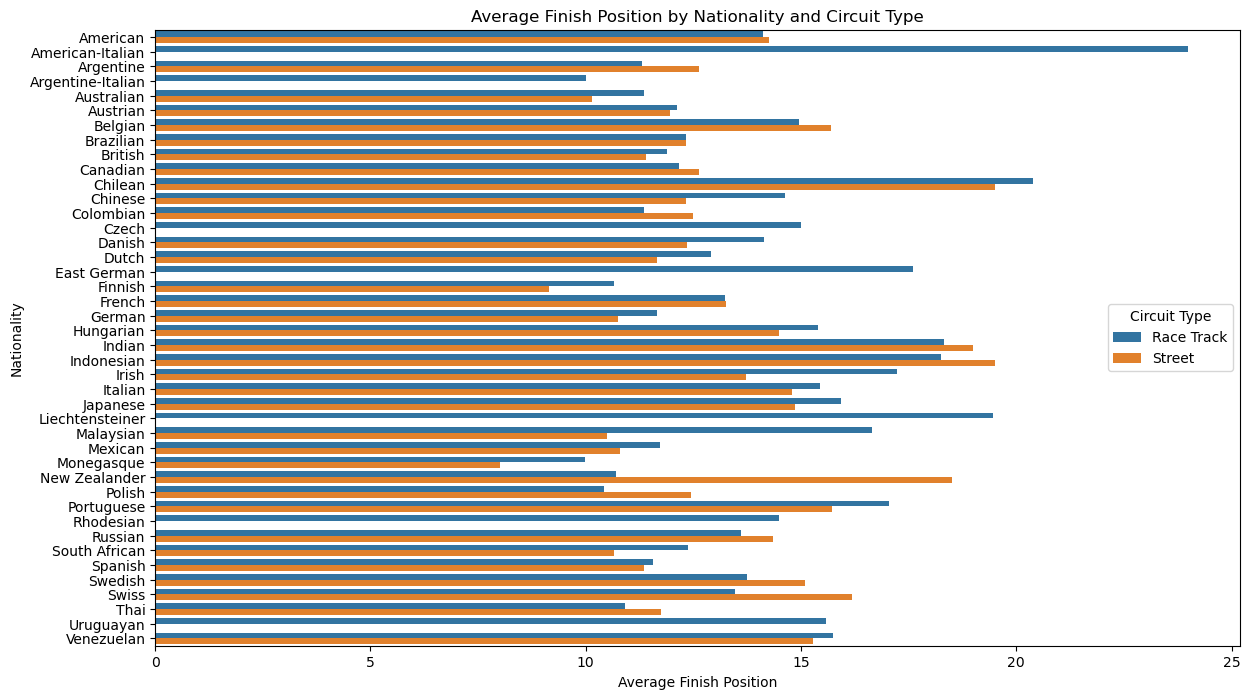

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualization
plt.figure(figsize=(14, 8))
sns.barplot(x='average_position', y='nationality', hue='circuitType', data=average_outcomes, ci=None)
plt.title('Average Finish Position by Nationality and Circuit Type')
plt.xlabel('Average Finish Position')
plt.ylabel('Nationality')
plt.legend(title='Circuit Type')
plt.show()


In [39]:
import pandas as pd

# Replace 'altitude_effects' with your DataFrame name
df = pd.DataFrame(altitude_effects)

# Ensure 'average_position' is numeric and handle NaNs
df['average_position'] = pd.to_numeric(df['average_position'], errors='coerce')
df = df.dropna(subset=['altitude_category', 'average_position'])

# Define a function to apply that checks the group size
def get_best_performance(group):
    if group['average_position'].size > 0:
        return group.loc[group['average_position'].idxmin()]
    else:
        return pd.Series()

# Apply the function to each group
best_performances = df.groupby('altitude_category').apply(get_best_performance).reset_index(drop=True)

best_performances


0     Argentine-Italian
1                0-500m
2                  10.0
3                   0.0
4                Polish
5             501-1000m
6              9.272727
7              2.363636
8         New Zealander
9            1001-1500m
10             9.315789
11             1.789474
12                Dutch
13           2001-3000m
14                4.125
15                15.25
dtype: object

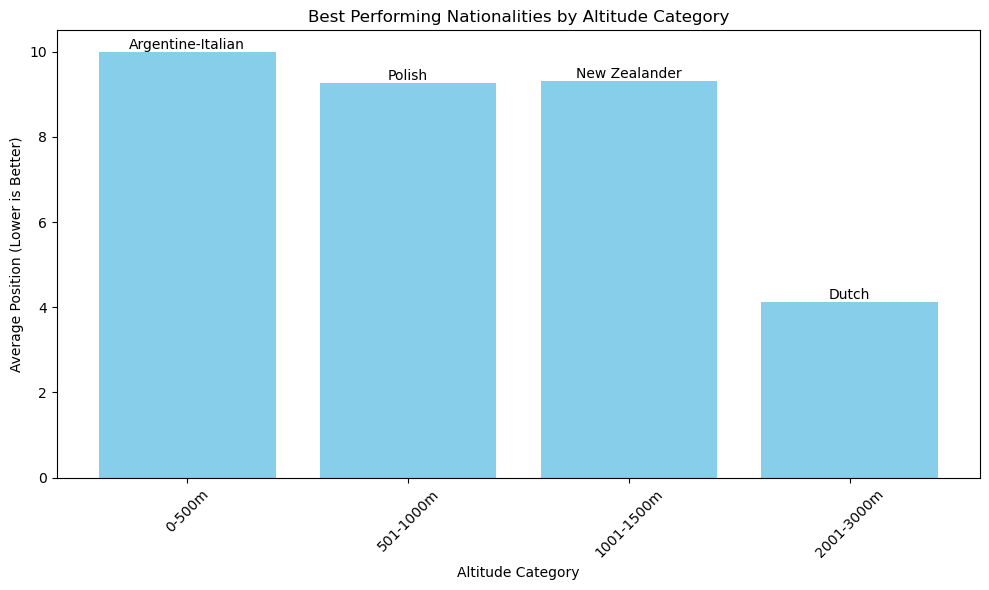

In [42]:
import matplotlib.pyplot as plt

# Sample data - replace this with your best_performances DataFrame
data = {
    'altitude_category': ['0-500m', '501-1000m', '1001-1500m', '2001-3000m'],
    'nationality': ['Argentine-Italian', 'Polish', 'New Zealander','Dutch'],
    'average_position': [10.0, 9.272727, 9.315789, 4.125],  # Lower is better
    'average_points':[0.0, 2.363636, 1.789474, 15.25]
}

best_performances = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(best_performances['altitude_category'], best_performances['average_position'], color='skyblue')

# Adding labels and title
plt.xlabel('Altitude Category')
plt.ylabel('Average Position (Lower is Better)')
plt.title('Best Performing Nationalities by Altitude Category')
plt.xticks(rotation=45)  # Rotate category labels for better readability

# Adding nationality labels on the bars
for index, value in enumerate(best_performances['average_position']):
    plt.text(index, value, str(best_performances['nationality'][index]), ha='center', va='bottom')

plt.tight_layout()
plt.show()

